In [43]:
import numpy as np
import pandas as pd
import xgboost as xgb
import re
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_fscore_support

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [45]:
X_holdout = pd.read_csv('test_values.csv')
X = pd.read_csv('train_values.csv')
y = pd.read_csv('train_labels.csv')
all_train = X.merge(y, left_on='building_id', right_on='building_id')
all_X = pd.concat([X, X_holdout], axis=0)

In [46]:
categorical_columns = ['geo_level_1_id','geo_level_2_id','geo_level_3_id',
                       'land_surface_condition','foundation_type','roof_type',
                       'ground_floor_type','other_floor_type','position',
                       'plan_configuration','legal_ownership_status']

miscoded_integers = ['has_secondary_use','count_families']

non_binary_integers = ['area','age','height','count_families','count_floors_pre_eq']

columns_to_drop = ['building_id','geo_level_3_id','has_secondary_use','land_surface_condition','position',
                    'plan_configuration','legal_ownership_status','has_secondary_use_agriculture', 'count_families',
                     'has_secondary_use_hotel','has_secondary_use_rental','has_secondary_use_institution',
                     'has_secondary_use_school','has_secondary_use_industry','has_secondary_use_health_post',
                     'has_secondary_use_gov_office','has_secondary_use_use_police','has_secondary_use_other','height']

In [47]:
all_X['area'] = all_X['area'].apply(lambda x: 100 if x > 100 else x)
all_X['age'] = all_X['age'].apply(lambda x: 50 if x > 50 else x)
all_X['height'] = all_X['height'].apply(lambda x: 8 if x > 8 else x)
all_X['count_floors_pre_eq'] = all_X['count_floors_pre_eq'].apply(lambda x: 4 if x > 4 else x)

In [48]:
#Converting float columns to integers.
for col in miscoded_integers:
    all_X[col] = all_X[col].astype('int64')
    all_train[col] = all_train[col].astype('int64')

#Converting categorical columns to categorical.
for col in categorical_columns:
    all_X[col] = all_X[col].astype('category')
    all_train[col] = all_train[col].astype('category')

#Scaling non-binary integers.
#for col in non_binary_integers:
#    all_X[col] = stats.boxcox(all_X[col])[0]
#    all_train[col] = stats.boxcox(all_train[col])[0]

#Dropping columns which do not have predictive value.
for col in columns_to_drop:
    all_X = all_X.drop([col], axis=1)
    all_train = all_train.drop([col], axis=1)

#Create dummies for categorical variables.
all_X = pd.get_dummies(all_X)
all_train = pd.get_dummies(all_train)

In [49]:
#Dropping outliers.

X = all_X.iloc[0:10000,:]
X_holdout = all_X.iloc[10000:,:]
y = y['damage_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=905)

In [50]:
#This classifier is used to determine feature importance. Hyperparameters are not tuned.

cls_model = xgb.XGBClassifier(subsample=0.7,
                              min_child_weight=1, objective="multi:softmax",
                              learning_rate=0.05, max_depth=7, n_estimators=1000)
#cls_model = xgb.XGBClassifier(objective="multi:softmax", seed=416)
cls_model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

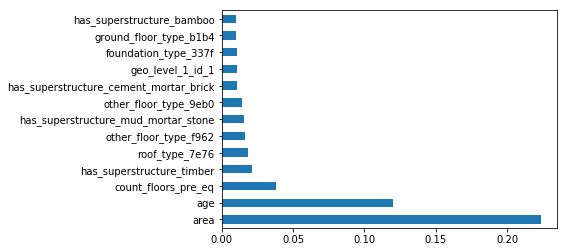

In [51]:
importance = cls_model.feature_importances_
importance_graph = pd.Series(importance, index=X_train.columns)
importance_graph = importance_graph.nlargest(100)[importance_graph > 0.01]
importance_graph.plot(kind='barh')

In [52]:
importance = cls_model.feature_importances_
importance_text = pd.Series(importance, index=X.columns)
importance_frame = pd.DataFrame(importance_text)
importance_frame.reset_index(inplace = True)
importance_frame.columns = ['feature_name','feature_importance']
#importance_frame.to_csv('importance.csv')
#importance_frame['colroot'] = importance_frame['feature_name'].apply(lambda x: get_root(x, categorical_columns))

In [53]:
y_pred = cls_model.predict(X_test)

In [54]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 121  181    8]
 [  95 1510  293]
 [   7  474  611]]


In [55]:
print('F1 micro score: {:.3%}'.format(f1_score(y_test, y_pred, average='micro')))

F1 micro score: 67.939%


Text(33,0.5,'True results')

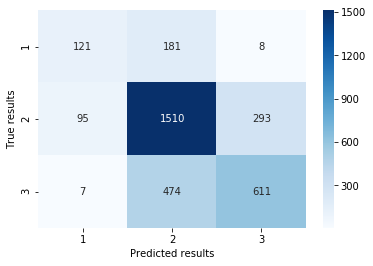

In [56]:
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels = [1,2,3], yticklabels = [1,2,3])
plt.xlabel('Predicted results')
plt.ylabel('True results')